Shape: (249231, 16)

Columns: ['route_id', 'driver_id', 'stop_id', 'address_id', 'week_id', 'country', 'day_of_week', 'indexp', 'indexa', 'arrived_time', 'earliest_time', 'latest_time', 'distancep', 'distancea', 'depot', 'delivery']

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249231 entries, 0 to 249230
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   route_id       249231 non-null  int64  
 1   driver_id      249231 non-null  int64  
 2   stop_id        249231 non-null  int64  
 3   address_id     249231 non-null  int64  
 4   week_id        249231 non-null  int64  
 5   country        249231 non-null  int64  
 6   day_of_week    249231 non-null  object 
 7   indexp         249231 non-null  int64  
 8   indexa         249231 non-null  int64  
 9   arrived_time   249231 non-null  float64
 10  earliest_time  249231 non-null  float64
 11  latest_time    249231 non-null  float64
 12 

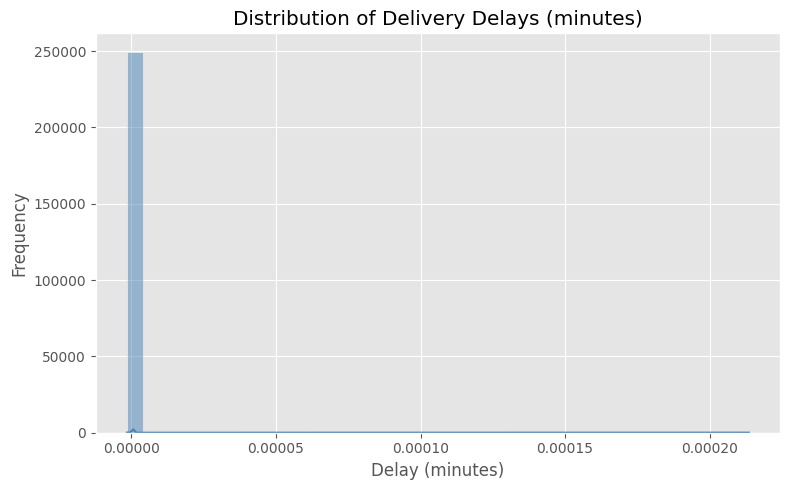

10.01% of deliveries were delayed.


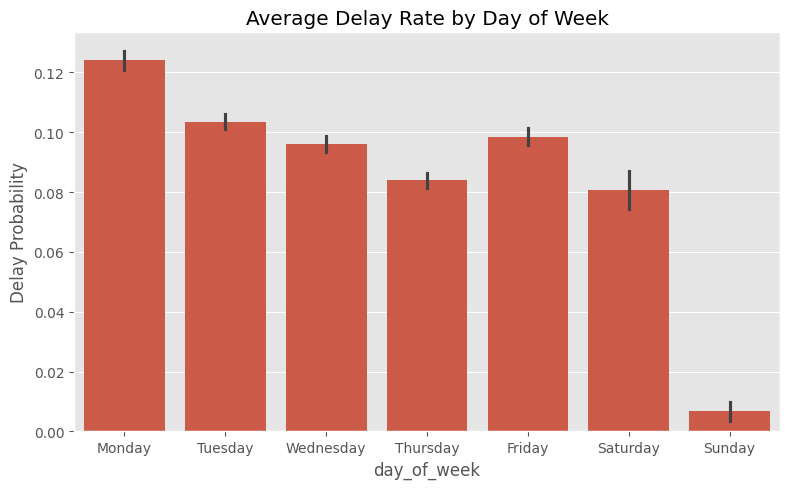

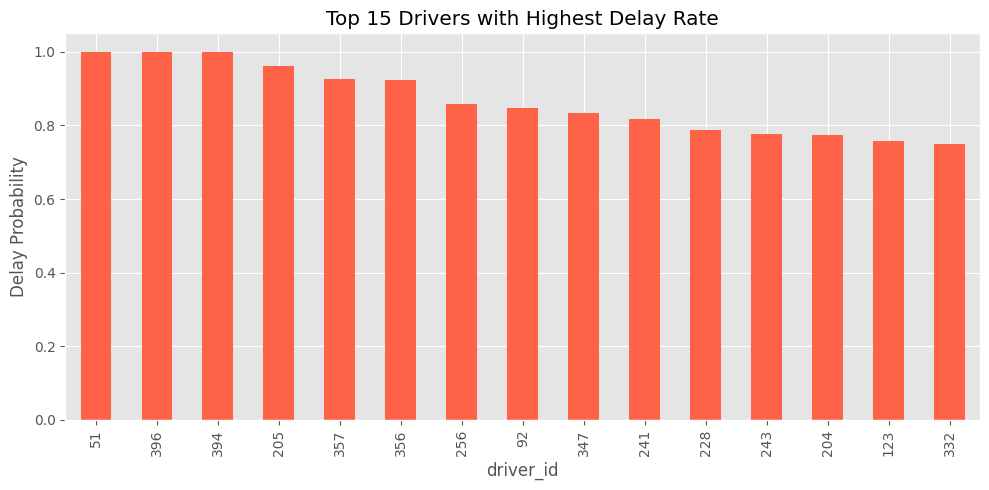

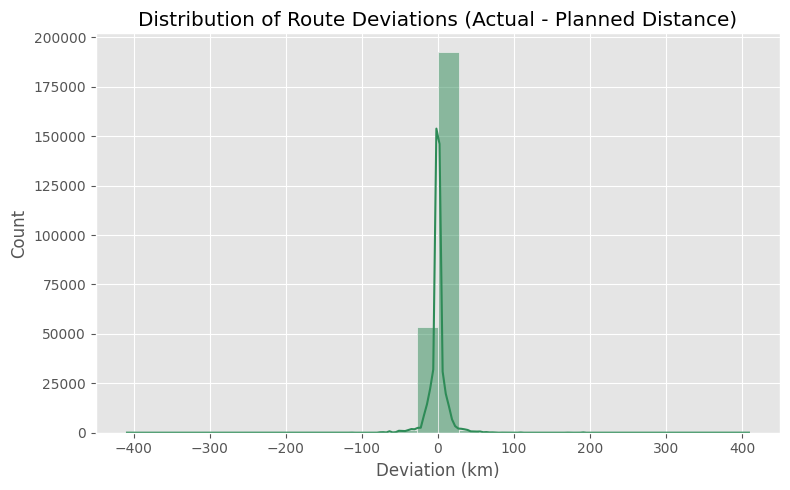

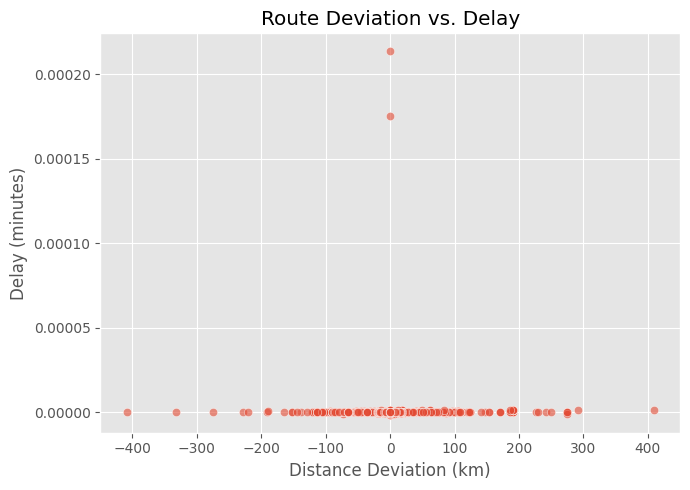


--- Correlation Matrix ---
                      distance_deviation  actual_arrival_delay  \
distance_deviation              1.000000              0.002637   
actual_arrival_delay            0.002637              1.000000   
planned_duration                0.004365             -0.011782   

                      planned_duration  
distance_deviation            0.004365  
actual_arrival_delay         -0.011782  
planned_duration              1.000000  


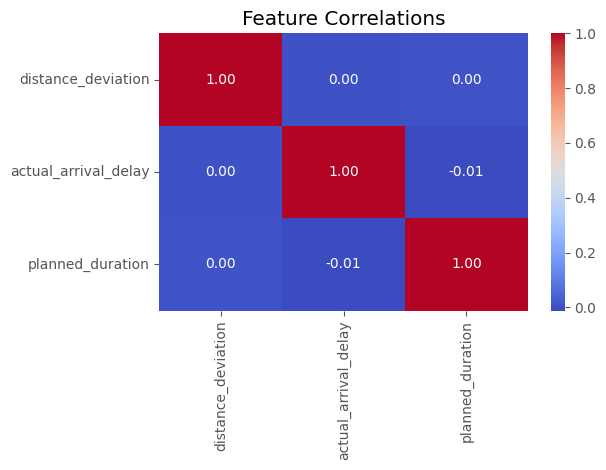

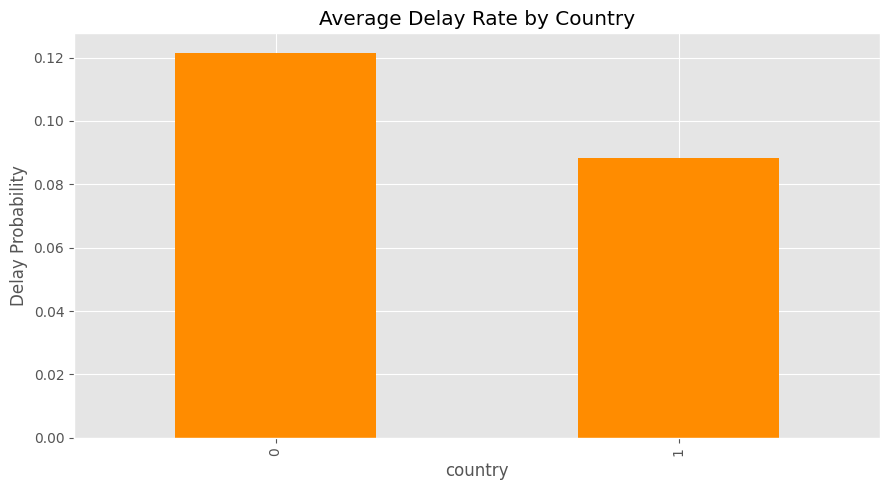

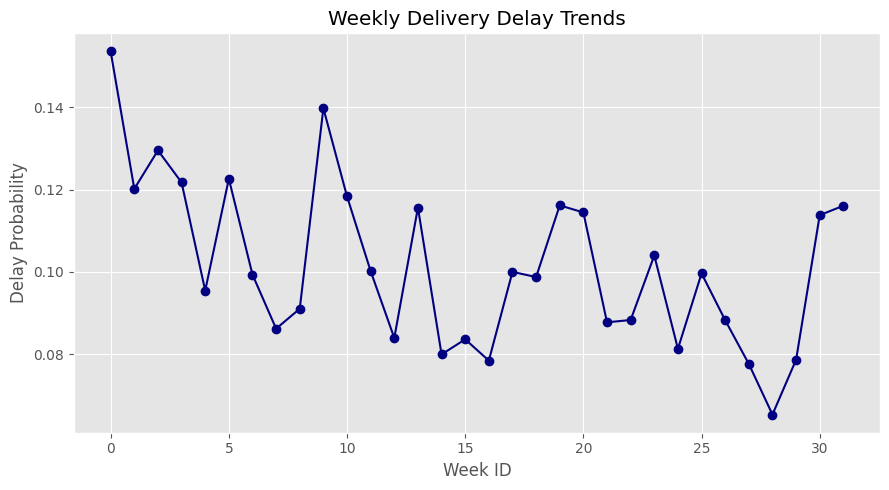


 Cleaned dataset saved to ../data/cleaned_delivery_data.csv

 EDA Summary:
Average delay rate: 10.01%
Avg route deviation: -0.08 km
Most delays occur on: Monday
Most delay-prone driver: 51 (delay rate: 1.00)


In [8]:
"""
EDA

Objective:
  - Explore delivery delay and route deviation patterns.
  - Identify correlations between timing, drivers, and route behavior.
  - Prepare insights for feature engineering and model design.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use("ggplot")


DATA_PATH = "../data/raw.xlsx"
df = pd.read_excel(DATA_PATH)

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())


print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Sample Records ---")
print(df.head(5))


# Convert time fields to datetime
time_cols = ["arrived_time", "earliest_time", "latest_time"]
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Compute derived features
df["planned_duration"] = (df["latest_time"] - df["earliest_time"]).dt.total_seconds() / 60
df["actual_arrival_delay"] = (df["arrived_time"] - df["latest_time"]).dt.total_seconds() / 60
df["delay_flag"] = np.where(df["actual_arrival_delay"] > 0, 1, 0)  # 1 if delayed

# Compute route deviation (difference between planned and actual distances)
df["distance_deviation"] = df["distancea"] - df["distancep"]



print("\n--- Basic Stats ---")
print(df[["distancep", "distancea", "distance_deviation", "actual_arrival_delay"]].describe())



# Distribution of delays
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="actual_arrival_delay", bins=40, kde=True, color="steelblue")
plt.title("Distribution of Delivery Delays (minutes)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Delay frequency
delay_rate = df["delay_flag"].mean() * 100
print(f"{delay_rate:.2f}% of deliveries were delayed.")

# Delay by day of week
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="day_of_week", y="delay_flag", estimator=np.mean)
plt.title("Average Delay Rate by Day of Week")
plt.ylabel("Delay Probability")
plt.tight_layout()
plt.show()

# Delay by driver
driver_delay = df.groupby("driver_id")["delay_flag"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
driver_delay.head(15).plot(kind="bar", color="tomato")
plt.title("Top 15 Drivers with Highest Delay Rate")
plt.ylabel("Delay Probability")
plt.tight_layout()
plt.show()


# Roure deviation analysis
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="distance_deviation", bins=30, kde=True, color="seagreen")
plt.title("Distribution of Route Deviations (Actual - Planned Distance)")
plt.xlabel("Deviation (km)")
plt.tight_layout()
plt.show()

# Relationship between route deviation and delay
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="distance_deviation", y="actual_arrival_delay", alpha=0.6)
plt.title("Route Deviation vs. Delay")
plt.xlabel("Distance Deviation (km)")
plt.ylabel("Delay (minutes)")
plt.tight_layout()
plt.show()

# Correlation
corr = df[["distance_deviation", "actual_arrival_delay", "planned_duration"]].corr()
print("\n--- Correlation Matrix ---")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.tight_layout()
plt.show()

# Country insights
country_delay = df.groupby("country")["delay_flag"].mean().sort_values(ascending=False)
plt.figure(figsize=(9, 5))
country_delay.plot(kind="bar", color="darkorange")
plt.title("Average Delay Rate by Country")
plt.ylabel("Delay Probability")
plt.tight_layout()
plt.show()

# Weekly and temporal patterns
weekly_delay = df.groupby("week_id")["delay_flag"].mean()
plt.figure(figsize=(9, 5))
weekly_delay.plot(marker="o", color="navy")
plt.title("Weekly Delivery Delay Trends")
plt.xlabel("Week ID")
plt.ylabel("Delay Probability")
plt.tight_layout()
plt.show()


CLEAN_PATH = "../data/cleaned_delivery_data.csv"
df.to_csv(CLEAN_PATH, index=False)
print(f"\n Cleaned dataset saved to {CLEAN_PATH}")


print("\n EDA Summary:")
print(f"Average delay rate: {delay_rate:.2f}%")
print(f"Avg route deviation: {df['distance_deviation'].mean():.2f} km")
print(f"Most delays occur on: {df.groupby('day_of_week')['delay_flag'].mean().idxmax()}")
print(f"Most delay-prone driver: {driver_delay.idxmax()} (delay rate: {driver_delay.max():.2f})")

